<a href="https://colab.research.google.com/github/talbio/conditional-gan/blob/main/cgan-pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import os
from PIL import Image

# Architecture

Let $C_k$ denote a Convolution-BatchNorm-ReLU layer
with $k$ filters. $CD_k$ denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of $50$%. All convolutions are $4 × 4$ spatial filters applied with stride $2$. Convolutions in the encoder, and in the discriminator, downsample
by a factor of $2$, whereas in the decoder they upsample by a
factor of $2$.

In [2]:
## this class implements CK, a Convolution-BatchNorm-ReLU layer with 𝑘 filters.
class CK(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

In [3]:
! pip install -q kaggle

In [5]:
from google.colab import files

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"talbio","key":"4254010b2491d291fffb3b936c09c93e"}'}

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download 'defileroff/comic-faces-paired-synthetic'

 98% 649M/662M [00:04<00:00, 178MB/s]
100% 662M/662M [00:04<00:00, 139MB/s]


In [ ]:
! unzip comic-faces-paired-synthetic.zip

In [10]:
! ls face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/

comics	face


## Discriminator

The 70 × 70 discriminator architecture is:
**C64-C128-C256-C512**
After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

In [18]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size=4,stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append( 
                CK(in_channels, feature, stride=(1 if feature == features[-1] else 2))
            )
            in_channels = feature
  
        # last layer, map to a 1 dimensional output
        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        # concatenate x and transormed image y on the channels dimension
        x = torch.cat([x,y], dim=1)
        x = self.initial(x)
        return self.model(x)

## Generator

In [11]:
class UnetLayerAbstract(nn.Module):
    def __init__(self, conv_layer, out_channels, act, use_dropout):
        super().__init__()
        self.conv = nn.Sequential(
            conv_layer,
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == 'relu' else nn.LeakyReLU(0.2), 
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x
 
class UnetLayerDown(UnetLayerAbstract):
    def __init__(self, in_channels, out_channels):
        super().__init__(nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect'),
                         out_channels,
                         act='leaky',
                         use_dropout = False)

class UnetLayerUp(UnetLayerAbstract):
    def __init__(self, in_channels, out_channels):
        super().__init__(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                         out_channels,
                         act='relu',
                         use_dropout = True)

In [12]:
a = [nn.Sequential(
            nn.Conv2d(2, 2, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
            )]

a += [nn.Sequential(
            nn.Conv2d(2, 2, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
            )]


liste = [nn.Sequential(
            nn.Conv2d(2, 2, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
            ), 
        nn.Sequential(
            nn.Conv2d(2, 2, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
            )]

b = nn.Sequential(*liste)

for l in b:
    print(l)

#print(a)
#a = nn.Sequential(*a)
#for l in a:
#  print('layer')
#  print(l)

Sequential(
  (0): Conv2d(2, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
  (1): LeakyReLU(negative_slope=0.2)
)
Sequential(
  (0): Conv2d(2, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
  (1): LeakyReLU(negative_slope=0.2)
)


In [13]:
class Generator(nn.Module):
    def __init__(self, in_channels = 3, features = 64):
        super().__init__()

        self.encoder = [
                         nn.Sequential(
                             nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
                             nn.LeakyReLU(0.2)
                             ),
                         UnetLayerDown(features, features*2),
                         UnetLayerDown(features*2, features*4),
                         UnetLayerDown(features*4, features*8)        
        ]
        self.encoder += [UnetLayerDown(features*8, features*8) for _ in range(0, 3)]
        self.encoder.append(
            nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode = 'reflect'),
            nn.ReLU()
          )
        )
        self.encoder = nn.Sequential(*self.encoder)
        
        # 1 x 1
        #self.bottleneck = nn.Sequential(
        #    nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode = 'reflect'),
        #    nn.ReLU()
        #)

        self.decoder = []
        self.decoder += [
                         UnetLayerUp(features*8, features*8),
                         UnetLayerUp(features*8*2, features*8),
                         UnetLayerUp(features*8*2, features*8),
                         UnetLayerUp(features*8*2, features*8),
                         UnetLayerUp(features*8*2, features*4),
                         UnetLayerUp(features*4*2, features*2),
                         UnetLayerUp(features*2*2, features),
                         nn.Sequential(
                             nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
                             nn.Tanh()
                             )
        ]
        self.decoder = nn.Sequential(*self.decoder)

        #self.final_layer = nn.Sequential(
        #    nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
        #    nn.Tanh()
        #    )


    def forward(self, x):
        decoder_output = []
        for layer in self.encoder:
            x = layer(x)
            decoder_output.append(x)
        
        x = self.decoder[0](x)

        for i, layer in enumerate(self.decoder[1:]):
            #print(f' decoder ouput {decoder_output[-i-2].shape}')
            #print(f' x outpout {x.shape}')
            x = layer(torch.cat([x, decoder_output[-i-2]], 1))

        return x


In [ ]:
def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)

test()

torch.Size([1, 3, 256, 256])


In [14]:

face2comics_path = 'face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/'
a = os.listdir(os.path.join(face2comics_path, 'face'))
sorted(a)
b = os.listdir(os.path.join(face2comics_path, 'comics'))
print(len(a))
print(b[:30])

IndentationError: ignored

Let's see an example

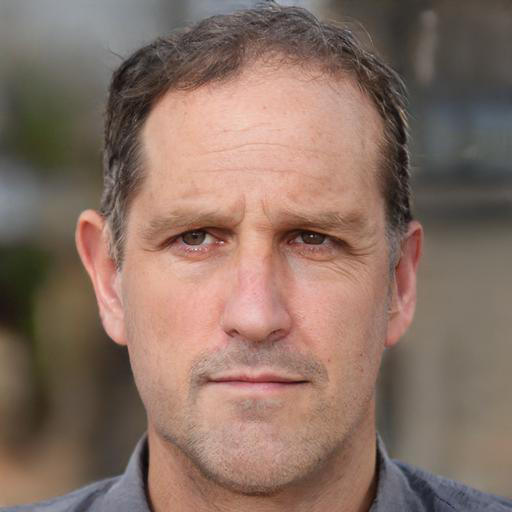

In [20]:
Image.open(os.path.join(face2comics_path, 'face/1.jpg'))

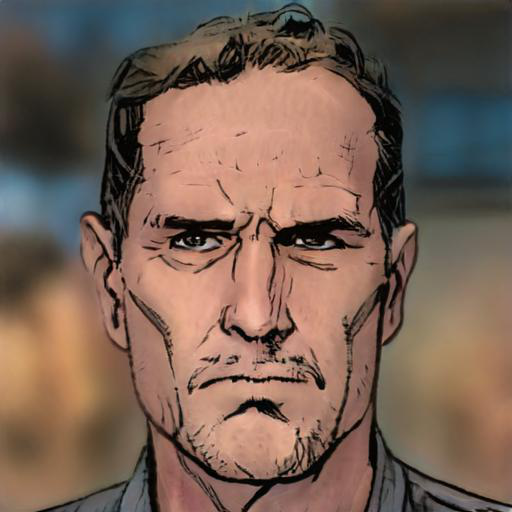

In [22]:
Image.open(os.path.join(face2comics_path, 'comics/1.jpg'))

In [26]:
np.array(Image.open(os.path.join(face2comics_path, 'comics/1.jpg'))).shape

(512, 512, 3)

In [15]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A

face2comics_path = 'face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/'

class ComicsDataset(Dataset):
    def __init__(self, root_dir, transforms=None, train=True):
        self.root_dir = root_dir
        self.face_dir = os.path.join(self.root_dir, 'face')
        self.comics_dir = os.path.join(self.root_dir, 'comics')
        self.faces_list_files = os.listdir(self.face_dir)[:8000] if train else os.listdir(self.face_dir)[8000:]
        self.comics_list_files = os.listdir(self.comics_dir)[:8000] if train else os.listdir(self.comics_dir)[8000:]
        self.transforms = transforms

    def __len__(self):
        return len(self.faces_list_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.face_dir, self.faces_list_files[index])
        input_image = np.array(Image.open(img_path))
        target_path = os.path.join(self.comics_dir, self.comics_list_files[index])
        target_image = np.array(Image.open(target_path))

        #input_image = image[:, :600, :]
        #target_image = image[:, 600:, :]

        if self.transforms:
          input_image = self.transforms(input_image)
          target_image = self.transforms(target_image)
                
        return input_image, target_image

In [16]:
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
from torchvision import  transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 100
LOAD_MODEL = False
SAVE_MODEL = False


D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

opt_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

tsfm = transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),
                    torchvision.transforms.Resize((256,256)),
                    ])

train_dataset = ComicsDataset(face2comics_path, transforms=tsfm, train=True)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

scaler = torch.cuda.amp.GradScaler()
val_dataset = ComicsDataset(face2comics_path, transforms=tsfm, train=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader,position=epoch, leave=True)
    print(f'epoch : {epoch}/{NUM_EPOCHS}')
    for idx, (x, y) in enumerate(loop):
  
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        with torch.cuda.amp.autocast():

            y_fake = G(x)
            D_real = D(x, y)
            D_real_loss = BCE(D_real, torch.ones_like(D_real))
            D_fake = D(x, y_fake.detach())
            D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        D.zero_grad()
        scaler.scale(D_loss).backward()
        scaler.step(opt_D)
        scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = D(x, y_fake)
            G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
            L1 = L1_LOSS(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_G.zero_grad()
        scaler.scale(G_loss).backward()
        scaler.step(opt_G)
        scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )
    if epoch % 20 == 0:
      save_some_examples(G, val_loader, epoch, folder="/content/gdrive/MyDrive/maps")

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0/100


100%|██████████| 500/500 [03:54<00:00,  2.13it/s, D_fake=0.315, D_real=0.287]


FileNotFoundError: ignored

In [22]:
save_some_examples(G, val_loader, epoch, folder="evaluation")

In [21]:
!mkdir evaluation

In [23]:
!cd evaluation && ls

input_0.png  y_gen_0.png


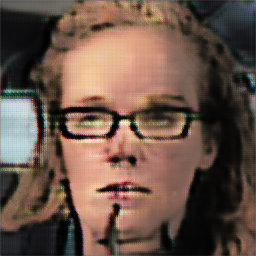

In [24]:
Image.open('evaluation/y_gen_0.png')

In [25]:
import torch
import torch.nn.functional as F

import numpy as np

def _fast_hist(input, target, num_classes):
    mask = (target >= 0) & (target < num_classes)
    hist = num_classes * target[mask].astype(int) + input[mask].astype(int)
    hist = np.bincount(hist, minlength=num_classes**2).reshape(num_classes, num_classes)
    return hist


def label_score(input, target, num_classes):
    input  = input.cpu().numpy()
    target = target.cpu().numpy()
    hist = np.zeros((num_classes, num_classes))
    for lp, lt in zip(input, target):
        hist += _fast_hist(lp.flatten(), lt.flatten(), num_classes)
    per_pixel_acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    per_class_acc = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    iou_acc = np.nanmean(iu)
    return per_pixel_acc, per_class_acc, iou_acc

In [26]:
def evaluate_label_score(gen, val_loader, epoch):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)

    with torch.no_grad():
      y_fake = gen(x)
      y_fake = y_fake * 0.5 + 0.5
      scores = label_score(y_fake, y, 2)
      print(scores)

In [78]:
evaluate_label_score(G, val_loader, epoch)

 ici : 0.9898244382872146
(0.9898244382872146, 0.9898244382872146, 0.4949122191436073)


In [27]:
from torchvision import models, transforms
import math
class InceptionScore(nn.Module):
    def __init__(self, state_dict=None, batch_size=32, splits=10):
        super(InceptionScore, self).__init__()
        self.batch_size = batch_size
        self.splits = splits
        self.model = models.inception_v3(pretrained=True).to(DEVICE)  # model pretrained on ImageNet
        if state_dict is not None:
            self.model.load_state_dict(state_dict)

    def forward(self, input):
        # Inception works only with 3x299x299 images. You can crop (like center crop or 10 crops)
        # the images or rescale them before feeding them into Inception.
        assert(input.shape[1] == 3 and input.shape[2] == 299 and input.shape[3] == 299)
        self.model.eval()

        n = input.shape[0]
        n_batches = int(math.ceil(float(n) / float(self.batch_size)))

        probs = []
        with torch.no_grad():
            for i in range(n_batches):
                start = i * self.batch_size
                end   = min((i+1) * self.batch_size, n)
                input_split = input[start:end]
                probs.append(self.model(input_split).softmax(dim=1))
        probs = torch.cat(probs, dim=0)

        scores = []
        for i in range(self.splits):
            start = i     * n // self.splits
            end   = (i+1) * n // self.splits
            probs_split = probs[start:end]
            p = probs_split.mean(dim=0,keepdim=True).log()
            # kl = F.kl_div(probs_split, p, reduction='none')
            kl = probs_split*(probs_split.log() - p)
            kl = kl.sum(dim=1).mean()
            scores.append(kl.exp().item())

        return np.mean(scores), np.std(scores)

In [55]:
inception_criterion  = InceptionScore()

tf = transforms.Compose([
                    torchvision.transforms.Resize((299,299)),
                    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
                    ])
print(tf(y_fake).squeeze(0).shape)


with torch.no_grad():
    t = []
    for i in range(0, 5):

        x, y = next(iter(val_loader))
        x, y = x.to(DEVICE), y.to(DEVICE)
        y_fake = G(x)
        y_fake = y_fake * 0.5 + 0.5
        t.append(tf(y_fake))
       
t = torch.cat(t, axis=0)
print(t.shape)

print(inception_criterion(t))

torch.Size([3, 299, 299])
torch.Size([5, 3, 299, 299])
(nan, nan)


In [44]:
a = torch.empty(0, 2, 3)
b = torch.empty(3, 2, 3)
x = torch.cat((a, b), 0)
print(x.shape)
a.shape

torch.Size([3, 2, 3])


torch.Size([0, 2, 3])